In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [3]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [4]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [5]:
mu0 = 0
sigma0 = 1

In [6]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weightsMC_0 = np.array([(np.random.normal(abs(x), epsilon)) for x in theta0_G
                      ])  # Detector smearing for synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
# Toy MC weights from "MC sampling"
weightsMC_unknown = np.array([
    (np.random.normal(abs(x), epsilon)) for x in theta_unknown_G
])  
# Detector smearing for synthetic sample
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G]) 
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

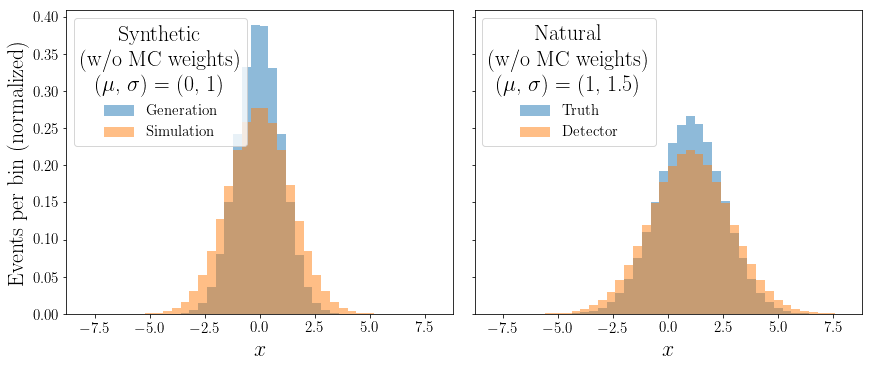

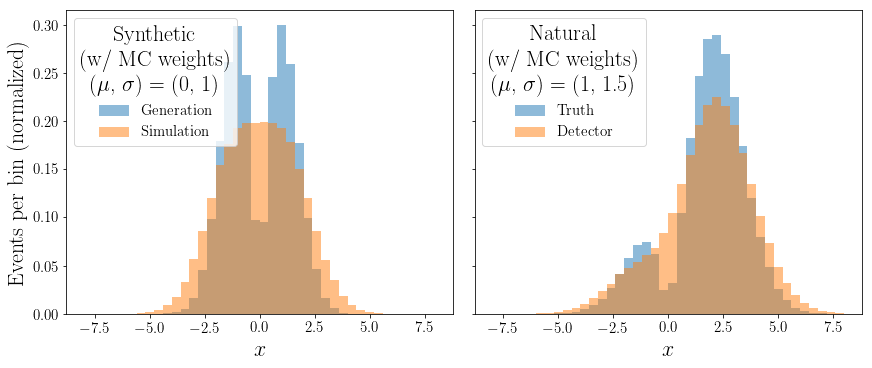

In [7]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Generation')
ax[0].hist(theta0_S,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Truth')
ax[1].hist(theta_unknown_S,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [8]:
iterations = 10

In [9]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [10]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [11]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [12]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1500000 samples, validate on 500000 samples
Epoch 1/200





1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6425 - acc: 0.6240 - val_loss: 0.6367 - val_acc: 0.6303
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6364 - acc: 0.6305 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6306 - val_loss: 0.6364 - val_acc: 0.6308
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6306 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6307 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6363 - acc: 0.6306 - val_loss:

Epoch 40/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6307 - val_loss: 0.6362 - val_acc: 0.6306
Epoch 41/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6307 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 42/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6308 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 43/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6306 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 44/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6307 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 45/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6308 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 46/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6362 - acc: 0.6308 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6788 - acc: 0.6200 - val_loss: 0.6778 - val_acc: 0.6215
Epoch 30/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6788 - acc: 0.6206 - val_loss: 0.6778 - val_acc: 0.6193
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6285 - acc: 0.4995 - val_loss: 0.6246 - val_acc: 0.5009
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6247 - acc: 0.4996 - val_loss: 0.6246 - val_acc: 0.5011
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6247 - acc: 0.4996 - val_loss: 0.6247 - val_acc: 0.5011
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6247 - acc: 0.4995 - val_loss: 0.6246 - val_acc: 0.5011
Epoch 5/200
1500000/

Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5000 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.5000
Epoch 8/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5000 - val_loss: 0.6084 - val_acc: 0.5000
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5000 - val_loss: 0.6085 - val_acc: 0.4998
Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5000 - val_loss: 0.6084 - val_acc: 0.5000
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6083 - acc: 0.5000 - val_loss: 0.6084 - val_acc: 0.4999
Epoch 13/2

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6894 - acc: 0.5561 - val_loss: 0.6907 - val_acc: 0.5654
Epoch 30/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6894 - acc: 0.5600 - val_loss: 0.6907 - val_acc: 0.5482
Epoch 31/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6894 - acc: 0.5571 - val_loss: 0.6908 - val_acc: 0.5510
Epoch 32/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6894 - acc: 0.5597 - val_loss: 0.6910 - val_acc: 0.5625
Epoch 33/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6894 - acc: 0.5605 - val_loss: 0.6908 - val_acc: 0.5496
Epoch 34/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6895 - acc: 0.5603 - val_loss: 0.6913 - val_acc: 0.5689
Epoch 35/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6895 - acc: 0.5640 - val_loss: 0.6909 - val_acc: 0.5530
Epoch 36/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5945 - acc: 0.5001 - val_loss: 0.5945 - val_acc: 0.4997
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5945 - acc: 0.5002 - val_loss: 0.5945 - val_acc: 0.4998
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5946 - acc: 0.5000 - val_loss: 0.5945 - val_acc: 0.4999
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5946 - acc: 0.5001 - val_loss: 0.5947 - val_acc: 0.4996
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5946 - acc: 0.5001 - val_loss: 0.5945 - val_acc: 0.4997
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5946 - acc: 0.5001 - val_loss: 0.5945 - val_acc: 0.4998
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5946 - acc: 0.5000 - val_loss: 0.5945 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6824 - acc: 0.4937 - val_loss: 0.6914 - val_acc: 0.4488
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6824 - acc: 0.4835 - val_loss: 0.6934 - val_acc: 0.4485
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6825 - acc: 0.4865 - val_loss: 0.6931 - val_acc: 0.5010
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6825 - acc: 0.4922 - val_loss: 0.6924 - val_acc: 0.5218
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6826 - acc: 0.5097 - val_loss: 0.6906 - val_acc: 0.5006
Epoch 18/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6824 - acc: 0.4936 - val_loss: 0.6946 - val_acc: 0.5006
Epoch 19/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6824 - acc: 0.4835 - val_loss: 0.6929 - val_acc: 0.5006
Epoch 20/200
150000

Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5910 - acc: 0.5003 - val_loss: 0.5906 - val_acc: 0.4995
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5910 - acc: 0.5001 - val_loss: 0.5906 - val_acc: 0.4994
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 10

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 5s 3us/step - loss: 0.7319 - acc: 0.5821 - val_loss: 0.6900 - val_acc: 0.6077
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6934 - acc: 0.5632 - val_loss: 0.6900 - val_acc: 0.5430
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6930 - acc: 0.5234 - val_loss: 0.6900 - val_acc: 0.5654
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6931 - acc: 0.5106 - val_loss: 0.6901 - val_acc:

ITERATION 1:


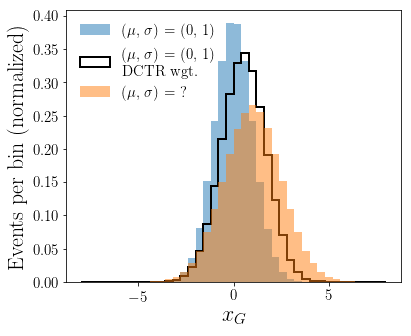

ITERATION 2:


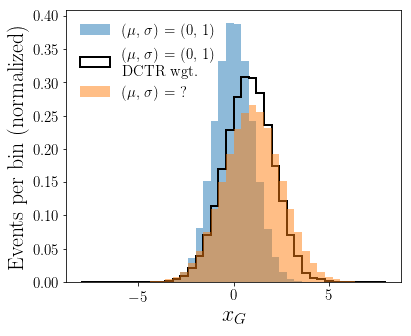

ITERATION 3:


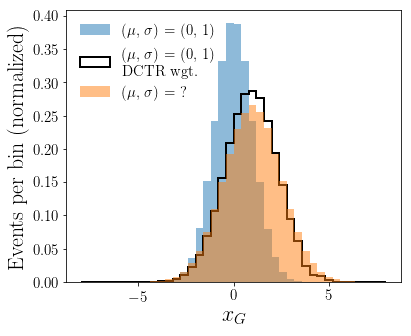

ITERATION 4:


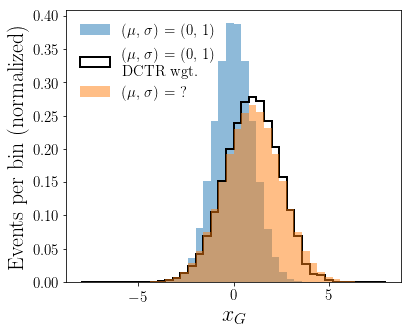

ITERATION 5:


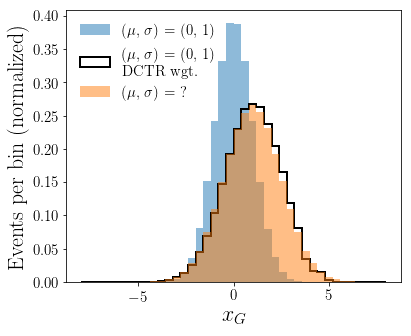

ITERATION 6:


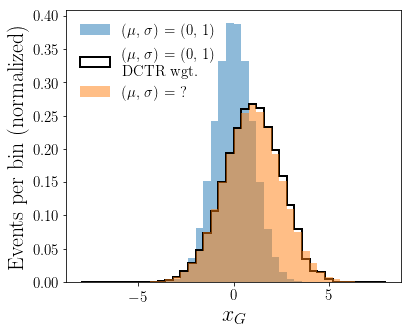

ITERATION 7:


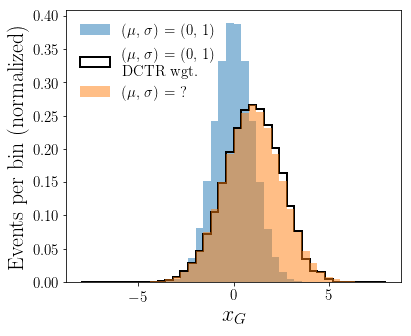

ITERATION 8:


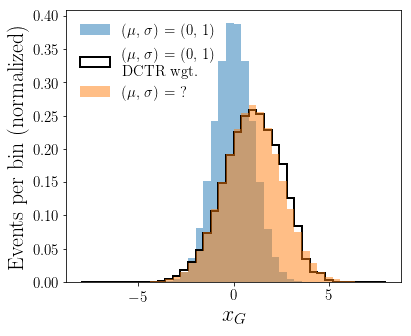

ITERATION 9:


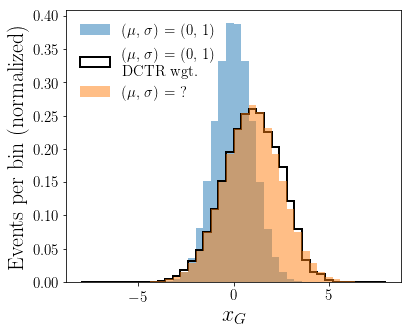

ITERATION 10:


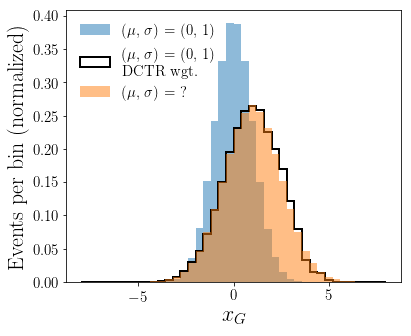

In [13]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold with initial MC weights

In [14]:
# initial iterative weights are MC weights

weights_pull = weightsMC_0
weights_push = weightsMC_0

In [15]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

In [16]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weightsMC_unknown))
    # actual weights for Sim., initial MC weights for Data

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weightsMC_0, weights_pull))
    # initial MC weights for Gen., actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)
    
    # note we need to take into account MC weights when reweighting the synthetic gen.
    weights_push = weightsMC_0 * reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 5s 3us/step - loss: 0.6202 - acc: 0.6198 - val_loss: 0.6145 - val_acc: 0.6161
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6176 - acc: 0.6168 - val_loss: 0.6141 - val_acc: 0.6176
Epoch 3/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6175 - acc: 0.6166 - val_loss: 0.6141 - val_acc: 0.6172
Epoch 4/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6175 - acc: 0.6164 - val_loss: 0.6141 - val_acc: 0.6177
Epoch 5/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6175 - acc: 0.6163 - val_loss: 0.6141 - val_acc: 0.6169
Epoch 6/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6175 - acc: 0.6168 - val_loss: 0.6140 - val_acc: 0.6178
Epoch 7/200
1500000/1500000 [==============================] - 3s 2us/step - l

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9574 - acc: 0.5968 - val_loss: 0.9600 - val_acc: 0.5946
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9576 - acc: 0.5967 - val_loss: 0.9600 - val_acc: 0.5989
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9576 - acc: 0.5966 - val_loss: 0.9599 - val_acc: 0.5962
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9575 - acc: 0.5977 - val_loss: 0.9602 - val_acc: 0.5998
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9574 - acc: 0.5974 - val_loss: 0.9600 - val_acc: 0.5918
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9576 - acc: 0.5962 - val_loss: 0.9611 - val_acc: 0.5871
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.9577 - acc: 0.5972 - val_loss: 0.9600 - val_acc: 0.5938
Epoch 18/200
150000

Epoch 8/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5723 - acc: 0.5001 - val_loss: 0.5736 - val_acc: 0.4996
Epoch 9/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5723 - acc: 0.5001 - val_loss: 0.5735 - val_acc: 0.4996
Epoch 10/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5724 - acc: 0.5002 - val_loss: 0.5734 - val_acc: 0.4995
Epoch 11/200
1500000/1500000 [==============================] - 4s 2us/step - loss: 1.0019 - acc: 0.4806 - val_loss: 1.0051 - val_acc: 0.5563
Epoch 21/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 1.0014 - acc: 0.4713 - val_loss: 1.0055 - val_acc: 0.5109
Epoch 22/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0017 - acc: 0.4469 - val_loss: 1.0060 - val_acc: 0.4759
Epoch 23/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0013 - acc: 0.4876 - val_loss: 1.0056 - val_acc: 0.5738
Epoch 2

Epoch 11/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5504 - acc: 0.5002 - val_loss: 0.5508 - val_acc: 0.4996
Epoch 12/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5503 - acc: 0.5002 - val_loss: 0.5506 - val_acc: 0.4995
Epoch 13/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5503 - acc: 0.5001 - val_loss: 0.5508 - val_acc: 0.4994
Epoch 14/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5503 - acc: 0.5001 - val_loss: 0.5507 - val_acc: 0.4995
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5503 - acc: 0.5002 - val_loss: 0.5509 - val_acc: 0.4998
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

ITERATION: 9

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 6s 4us/step - loss: 1.1671 - acc: 0.5420 - val_loss: 1.0029 - val_ac

1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0063 - acc: 0.5443 - val_loss: 0.9976 - val_acc: 0.6267
Epoch 15/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0062 - acc: 0.5574 - val_loss: 0.9984 - val_acc: 0.5271
Epoch 16/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0068 - acc: 0.5285 - val_loss: 0.9981 - val_acc: 0.5237
Epoch 17/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 1.0066 - acc: 0.5354 - val_loss: 0.9976 - val_acc: 0.5499
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 6s 4us/step - loss: 0.5873 - acc: 0.4996 - val_loss: 0.5599 - val_acc: 0.4993
Epoch 2/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.5599 - acc: 0.5002 - val_loss: 0.5600 - val_acc: 0.4994
Epoch 3/200
150000

ITERATION 1:


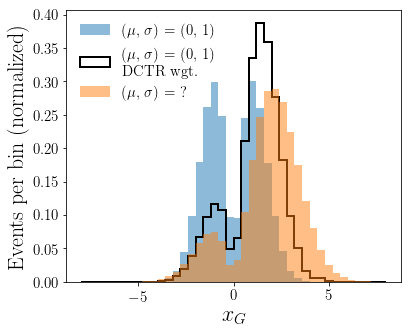

ITERATION 2:


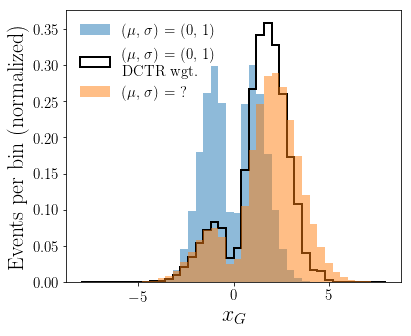

ITERATION 3:


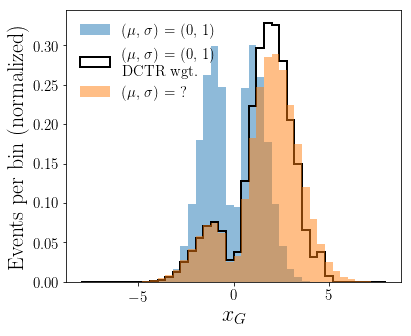

ITERATION 4:


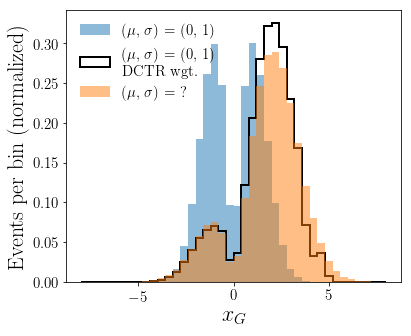

ITERATION 5:


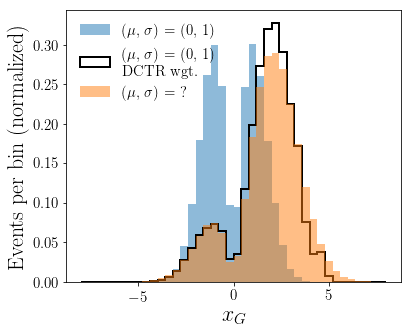

ITERATION 6:


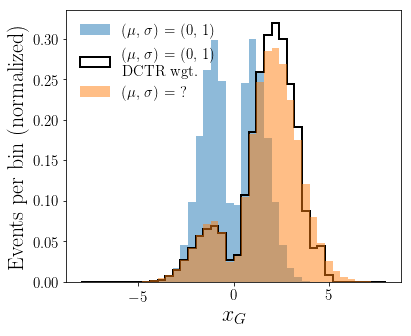

ITERATION 7:


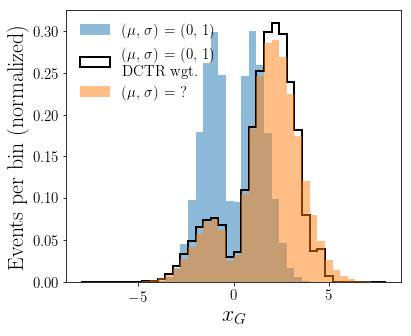

ITERATION 8:


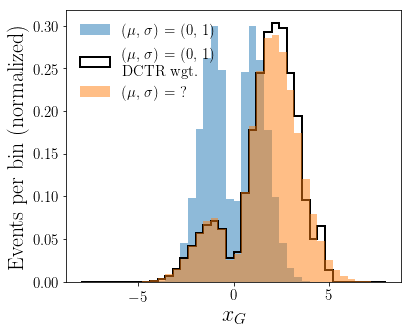

ITERATION 9:


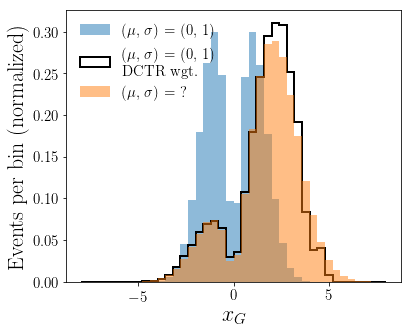

ITERATION 10:


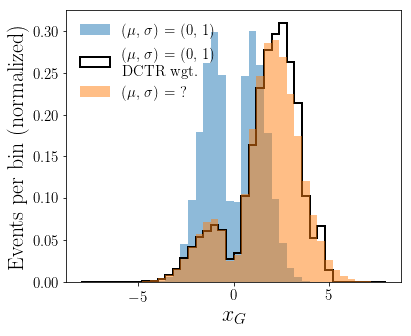

In [17]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     weights=weightsMC_0,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     weights=weightsMC_unknown,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()